In [ ]:
import numpy as np
import pandas as pd
import nltk
import string
import re
from nltk.corpus import stopwords
import tensorflow as tf
import matplotlib as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import GRU, Dense, Embedding, LSTM, Bidirectional
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Project RM/SingleLabel RAW.csv"
df = pd.read_csv(path)

Mounted at /content/drive


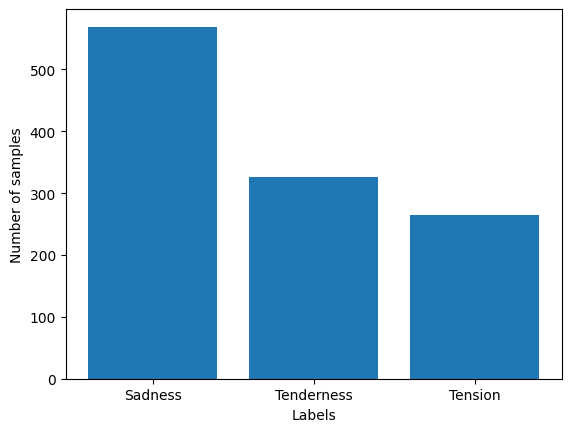

In [ ]:
# Count number of samples for each label
label_counts = df['label'].value_counts()

# Plot the data distribution
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
# x_raw = df['lyrics'].values
# y = df['label'].values
x_raw = df.lyrics
#y = df.label
#['Sadness' 'Tension' 'Tenderness']
label = {'Sadness':0, 'Tension':1, 'Tenderness':2}
df['id_label'] = pd.Categorical(df['label']).codes
y = df.id_label

# # clean text
str_punc = string.punctuation.replace(',', '').replace("'", '').replace('!', '').replace('?', '')

def clean_text(text):
  x = [x.lower() for x in x_raw]
  x = [re.sub(r'[^A-Za-z]+', ' ', x) for x in x_raw]
  return x

x_raw = clean_text(x_raw)
df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

max_features = 10000
max_len = 200
batch_size = 32
epochs = 5
embedding_dims = 32
hidden_dims = 32

# Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_raw)
seq = tokenizer.texts_to_sequences(x_raw)
X = pad_sequences(seq, maxlen=max_len)
y = np.asarray(y)

#Data Balancing
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

#LSTM-GRU hybrid model
model = Sequential()
model.add(Embedding(max_features, 50, input_length = max_len))
model.add(Bidirectional(LSTM(units=32, dropout=0.2, return_sequences=True)))
model.add(Bidirectional(GRU(units=32, dropout=0.2)))
model.add(Dense(units=3, activation='softmax'))

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Training the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_acc)

Epoch 1/20
44/44 [==============================] - 9s 64ms/step - loss: 1.0889 - accuracy: 0.3792 - val_loss: 1.0607 - val_accuracy: 0.4351 - lr: 0.0010
Epoch 2/20
44/44 [==============================] - 1s 25ms/step - loss: 0.8005 - accuracy: 0.6136 - val_loss: 0.7543 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 3/20
44/44 [==============================] - 1s 25ms/step - loss: 0.4269 - accuracy: 0.8336 - val_loss: 0.7007 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 4/20
44/44 [==============================] - 1s 26ms/step - loss: 0.1876 - accuracy: 0.9436 - val_loss: 0.6894 - val_accuracy: 0.7597 - lr: 0.0010
Epoch 5/20
44/44 [==============================] - 1s 25ms/step - loss: 0.0879 - accuracy: 0.9754 - val_loss: 0.8842 - val_accuracy: 0.7468 - lr: 0.0010
Epoch 6/20
44/44 [==============================] - 1s 25ms/step - loss: 0.0444 - accuracy: 0.9870 - val_loss: 0.8751 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 7/20
44/44 [==============================] - 1s 25ms/step - loss: 0.0

In [ ]:
# Predict
y_pred = model.predict(X_test)

# Convert predictions from probabilities to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

# Print metrics
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1)
print('Accuracy: ', accuracy)


6/6 [==============================] - 0s 17ms/step
Precision:  0.7861148066026115
Recall:  0.7539011979893026
F1 Score:  0.7604474680776955
Accuracy:  0.7543859649122807


Tambahin pre train model sbg FE terus di freeze, Back prop hanya di layer setelah freeze

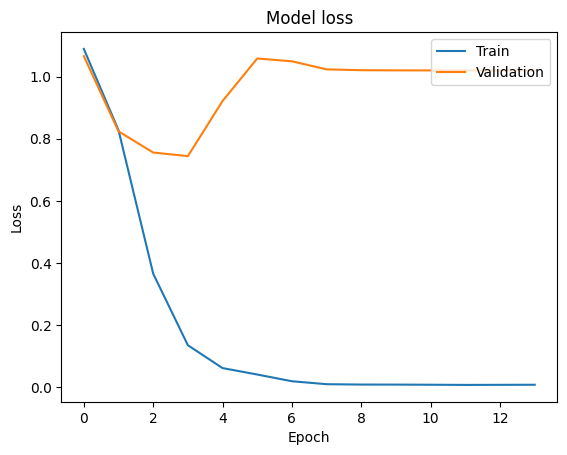

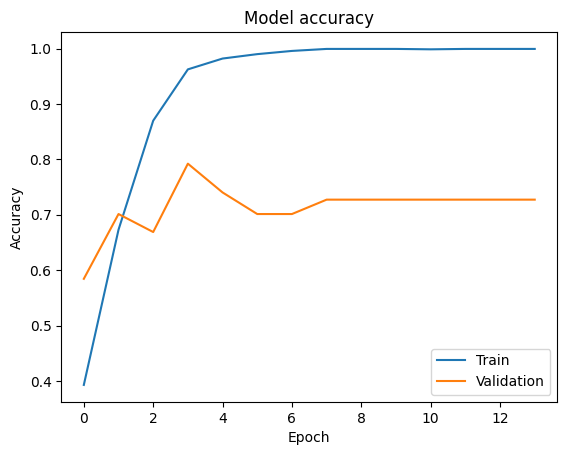

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


6/6 [==============================] - 0s 30ms/step
Confusion Matrix:
[[37  9 11]
 [17 43  1]
 [11  1 41]]


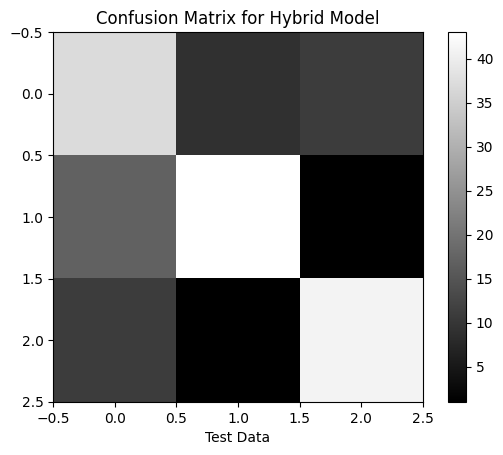

In [ ]:
import matplotlib.pyplot as plt
# Import confusion matrix
from sklearn.metrics import confusion_matrix

# Predict using test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print('Confusion Matrix:')
plt.imshow(cm, cmap = plt.cm.gray)
plt.title("Confusion Matrix for Hybrid Model")
plt.colorbar()
plt.xlabel("Prediction Data")
plt.xlabel("Test Data")
print(cm)
plt.show()

In [ ]:
# x_raw = df['lyrics'].values
# y = df['label'].values
x_raw = df.lyrics
#y = df.label
#['Sadness' 'Tension' 'Tenderness']
label = {'Sadness':0, 'Tension':1, 'Tenderness':2}
df['id_label'] = pd.Categorical(df['label']).codes
y = df.id_label

# # clean text
str_punc = string.punctuation.replace(',', '').replace("'", '').replace('!', '').replace('?', '')

def clean_text(text):
  x = [x.lower() for x in x_raw]
  x = [re.sub(r'[^A-Za-z]+', ' ', x) for x in x_raw]
  return x

x_raw = clean_text(x_raw)
df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

max_features = 10000
max_len = 200
batch_size = 32
epochs = 5
embedding_dims = 32
hidden_dims = 32

# Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_raw)
seq = tokenizer.texts_to_sequences(x_raw)
X = pad_sequences(seq, maxlen=max_len)
y = np.asarray(y)

#Data Balancing
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

#LSTM-GRU hybrid model
model = Sequential()
model.add(Embedding(max_features, 50, input_length = max_len))
model.add(Bidirectional(LSTM(units=32, dropout=0.5, return_sequences=True)))
model.add(Bidirectional(GRU(units=32, dropout=0.5)))
model.add(Dense(units=3, activation='softmax'))

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Training the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_acc)

Epoch 1/20
44/44 [==============================] - 9s 79ms/step - loss: 1.0914 - accuracy: 0.4103 - val_loss: 1.0655 - val_accuracy: 0.5390 - lr: 0.0010
Epoch 2/20
44/44 [==============================] - 2s 37ms/step - loss: 0.8770 - accuracy: 0.5962 - val_loss: 0.8222 - val_accuracy: 0.5909 - lr: 0.0010
Epoch 3/20
44/44 [==============================] - 1s 28ms/step - loss: 0.5867 - accuracy: 0.7388 - val_loss: 0.7904 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 4/20
44/44 [==============================] - 1s 29ms/step - loss: 0.3689 - accuracy: 0.8531 - val_loss: 0.7442 - val_accuracy: 0.7338 - lr: 0.0010
Epoch 5/20
44/44 [==============================] - 1s 27ms/step - loss: 0.2032 - accuracy: 0.9175 - val_loss: 0.8158 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 6/20
44/44 [==============================] - 1s 27ms/step - loss: 0.0947 - accuracy: 0.9703 - val_loss: 0.8558 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 7/20
44/44 [==============================] - 1s 27ms/step - loss: 0.0

In [ ]:
# Predict
y_pred = model.predict(X_test)

# Convert predictions from probabilities to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

# Print metrics
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1)
print('Accuracy: ', accuracy)

6/6 [==============================] - 1s 17ms/step
Precision:  0.7244554093567253
Recall:  0.7228019528148136
F1 Score:  0.7232575938227446
Accuracy:  0.7251461988304093


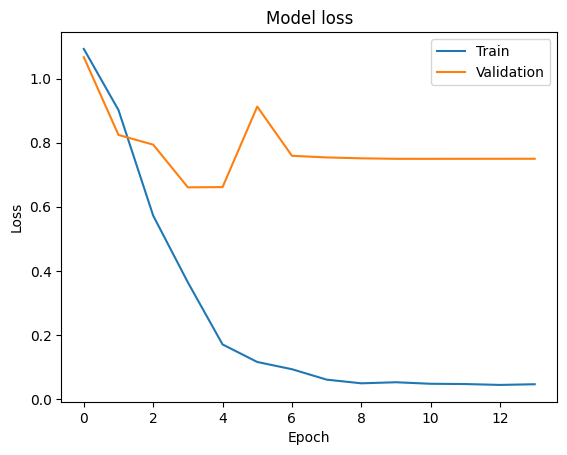

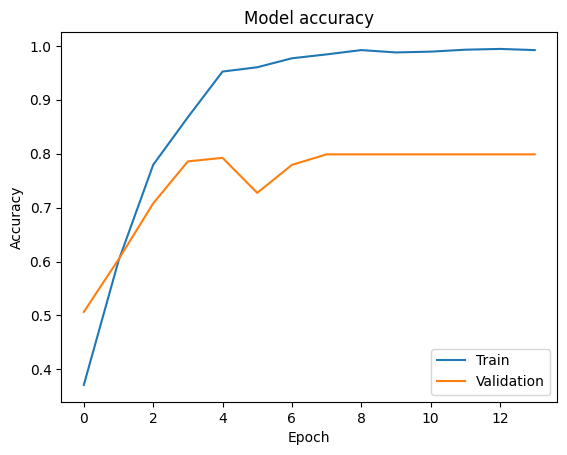

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
